<a href="https://colab.research.google.com/github/Muhammad-Abdullah-Jami/BERT-LLM/blob/main/Ber_AG_news_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing important libraries

In [4]:
# !pip install transformers[torch] --upgrade
# !pip install accelerate --upgrade
# !pip install datasets
# !pip install datasets pandas

### importing libraries

In [16]:
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from torch.utils.data import Dataset

### loading  AG news dataset

In [5]:


# Load the AG News dataset
dataset = load_dataset("ag_news")

# Convert the training set to a Pandas DataFrame
df_train = pd.DataFrame(dataset['train'])

# Convert the test set to a Pandas DataFrame
df_test = pd.DataFrame(dataset['test'])

# Display the structure of the DataFrame

df_train


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2
...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0
119996,Renteria signing a top-shelf deal Red Sox gene...,1
119997,Saban not going to Dolphins yet The Miami Dolp...,1
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1


In [6]:
df_test

,text,label
0,Fears for T N pension after talks Unions repre...,2
1,The Race is On: Second Private Team Sets Launc...,3
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3
...,...,...
7595,Around the world Ukrainian presidential candid...,0
7596,Void is filled with Clement With the supply of...,1
7597,Martinez leaves bitter Like Roger Clemens did ...,1
7598,5 of arthritis patients in Singapore take Bext...,2


### EDA

In [7]:
# Basic info about the dataset
print("Training Set Info:")
print(df_train.info())
print("\nTest Set Info:")
print(df_test.info())

# Checking the distribution of classes
print("\nClass Distribution in Training Set:")
print(df_train['label'].value_counts())

print("\nClass Distribution in Test Set:")
print(df_test['label'].value_counts())


Training Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    120000 non-null  object
 1   label   120000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB
None

Test Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7600 non-null   object
 1   label   7600 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.9+ KB
None

Class Distribution in Training Set:
label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64

Class Distribution in Test Set:
label
2    1900
3    1900
1    1900
0    1900
Name: count, dtype: int64


<ipython-input-8-417ff1da94ad>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x='label', palette='viridis')


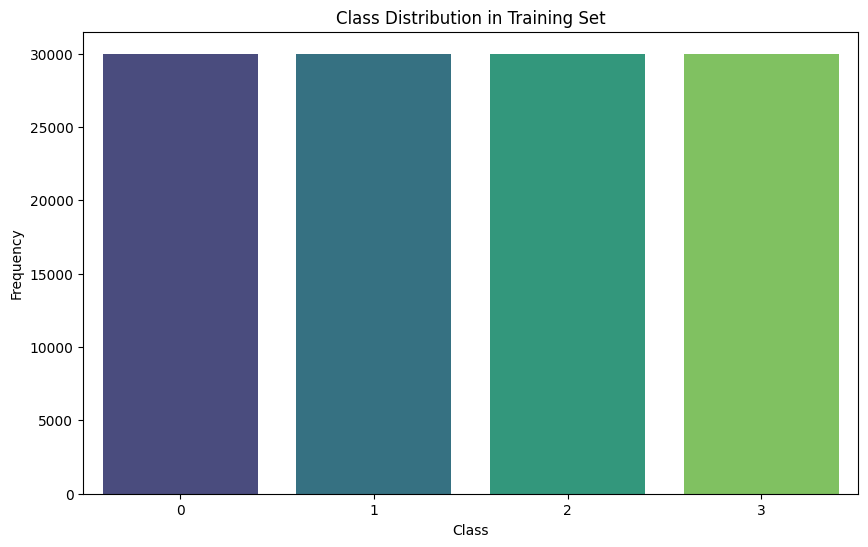

In [8]:
# Plotting the distribution of classes
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x='label', palette='viridis')
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


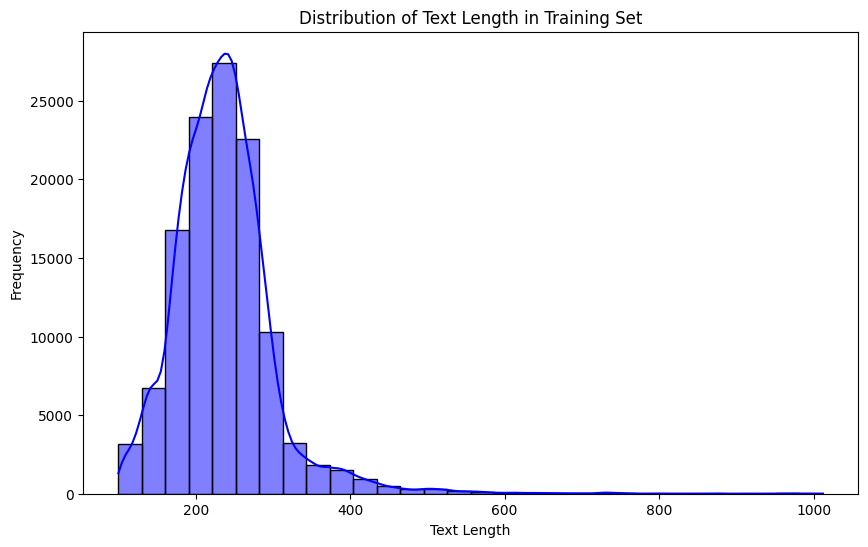

In [9]:
# Checking the length of text in the dataset
df_train['text_length'] = df_train['text'].apply(len)

# Plotting the distribution of text length
plt.figure(figsize=(10, 6))
sns.histplot(df_train['text_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Text Length in Training Set')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Displaying some samples from each class
for i in range(len(df_train['label'].unique())):
    print(f"\nSample from Class {i}:")
    print(df_train[df_train['label'] == i]['text'].iloc[0])



Sample from Class 0:
Venezuelans Vote Early in Referendum on Chavez Rule (Reuters) Reuters - Venezuelans turned out early\and in large numbers on Sunday to vote in a historic referendum\that will either remove left-wing President Hugo Chavez from\office or give him a new mandate to govern for the next two\years.

Sample from Class 1:
Phelps, Thorpe Advance in 200 Freestyle (AP) AP - Michael Phelps took care of qualifying for the Olympic 200-meter freestyle semifinals Sunday, and then found out he had been added to the American team for the evening's 400 freestyle relay final. Phelps' rivals Ian Thorpe and Pieter van den Hoogenband and teammate Klete Keller were faster than the teenager in the 200 free preliminaries.

Sample from Class 2:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Sample from Class 3:
'Madden,' 'ESPN' Football Score in Different Ways (Reuters) Reuters - Was absenteeis

### Preprocessing

In [17]:
# Load the AG News dataset into DataFrames (assuming df_train and df_test are already loaded)
df = pd.concat([df_train, df_test])

# Encode the labels (you already have label_mapping)
df['label'] = df['label'].map(label_mapping)

# Splitting the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizing the text data
def tokenize_data(df, tokenizer):
    return tokenizer(
        df['text'].tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

# Tokenize the training and validation data
train_encodings = tokenize_data(train_df, tokenizer)
val_encodings = tokenize_data(val_df, tokenizer)

# Convert labels to tensor format
def encode_labels(df, label_mapping):
    return torch.tensor(df['label'].map({v: k for k, v in label_mapping.items()}).values)

train_labels = encode_labels(train_df, label_mapping)
val_labels = encode_labels(val_df, label_mapping)

# Create a custom Dataset class
class AGNewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: tensor[idx] for key, tensor in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create the PyTorch datasets
train_dataset = AGNewsDataset(train_encodings, train_labels)
val_dataset = AGNewsDataset(val_encodings, val_labels)

# Now you can proceed with your Trainer setup


In [18]:
# Print out the structure of the tokenized data
print("Training Encodings:")
print(train_encodings)

print("Training Labels:")
print(train_labels)

print("Validation Encodings:")
print(val_encodings)

print("Validation Labels:")
print(val_labels)

Training Encodings:
{'input_ids': tensor([[  101,  3189,  1024,  ...,     0,     0,     0],
        [  101, 24582, 11639,  ...,     0,     0,     0],
        [  101, 23466,  2000,  ...,     0,     0,     0],
        ...,
        [  101, 28346,  6862,  ...,     0,     0,     0],
        [  101,  7160,  8576,  ...,     0,     0,     0],
        [  101, 26665,  5829,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}
Training Labels:
tensor([3, 3, 1,  ..., 0, 2, 2])
Validation Encodings:
{'input_ids': tensor([[  101,  2457, 19164,  ...,     0, 

### Preparing the Data for the BERT Model

In [ ]:
# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Define the metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'f1': f1, 'accuracy': acc}

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
